In [71]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from fuzzywuzzy import process
import matplotlib.pyplot as plt
# import tensorflow as tf

# Kaggle datasets used
# https://www.kaggle.com/datasets/mattop/college-football-bowl-games-1902-2022
# https://www.kaggle.com/datasets/jeffgallini/college-football-team-stats-2019?select=cfb17.csv
# https://www.kaggle.com/datasets/thedevastator/analyzing-college-football-2022-wins-losses-rank?select=games2022.csv

In [143]:
def load_stats() -> pd.DataFrame:
    stats_list = []
    for yr in range(13, 23):
        print(f"Loading data/cfb{yr}.csv")
        df = pd.read_csv(f'data/cfb{yr}.csv')

        # Make sure there are no unnamed columns
        df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

        # Add year column
        df['year'] = yr

        stats_list.append(df)

    print("Concatenating stats")

    stats_df = pd.concat(stats_list, sort=False)
    # Drop any columns that are have any missing values
    stats_df = stats_df.dropna(axis=1, how='any')

    assert "Team" in stats_df.columns, "Team column not found"

    # Sanitize the stats data
    # Remove the division from the team name
    stats_df['Team'] = stats_df['Team'].str.replace(r'\([^\(\)]*\)$', '')

    # Strip out spaces and special characters
    stats_df['Team'] = stats_df['Team'].str.replace(r'[^a-zA-Z0-9\(\)]', '')

    # Remove the banned columns
    BANNED_COLUMNS = [
        "Time.of.Possession",
        "Average.Time.of.Possession.per.Game",
    ]
    stats_df = stats_df.drop(columns=BANNED_COLUMNS)


    # Remove any commmas from the numbers
    stats_df.replace(',','', regex=True, inplace=True)

    # Output it to a csv for funs sake
    stats_df.to_csv('stats.csv', index=False)

    # Multi-index
    stats_multi_df = stats_df.set_index(['year', 'Team'])
    stats_multi_df.to_csv('stats_m.csv')
    return stats_multi_df

stats = load_stats()

Loading data/cfb13.csv
Loading data/cfb14.csv
Loading data/cfb15.csv
Loading data/cfb16.csv
Loading data/cfb17.csv
Loading data/cfb18.csv
Loading data/cfb19.csv
Loading data/cfb20.csv
Loading data/cfb21.csv
Loading data/cfb22.csv
Concatenating stats


In [121]:
def load_training_data():
    # Load up the all bowl games csv
    bowl_games = pd.read_csv("data/all_bowl_games.csv")

    # see how many gamse were played in the last 9 years
    bowl_games = bowl_games[bowl_games['year'] >= 2013]

    # Write these back to a csv
    bowl_games.to_csv('data/all_bowl_games.csv', index=False)

    # Create a new dataframe with the columns we want
    # training_data = pd.DataFrame(columns=['year', 'team1', 'team2', 'team1_win'] + ["1_" + col for col in team_data_cols] + ["2_" + col for col in team_data_cols])
    columns = ['year', 'team0', 'team1', 'winning_team']
    training_data = pd.DataFrame(columns=columns)

    for i, row in bowl_games.iterrows():
        year = row["year"] % 100
        if np.random.rand() > .5:
            new_row = [
                year, 
                row['winner_tie'],
                row['loser_tie'],
                0,
            ]   
        else:
            new_row = [
                year, 
                row['loser_tie'],
                row['winner_tie'],
                1,
            ]
        # Add the add the row to the training data
        training_data.loc[len(training_data)] = new_row # type: ignore
    training_data.to_csv('training_data.csv', index=False)
    return training_data

training_data = load_training_data()


In [122]:
# Handle name fixing
def fix_names(name) -> str:
    custom_mapping = {
        "Texas Christian": "TCU",
        "Army": "Army West Point",
        "Middle Tennessee State": "Middle Tenn",
        "Florida International": "FIU",
        "Alabama-Birmingham": "UAB",
        "Central Florida": "UCF",
        "South Florida": "South Fla",
        "Miami": "Miami (FL)",
        "Connecticut": "UConn",
        "North Carolina State": "NCState",
        "Appalachian State": "App State",
        "Bringham Young": "BYU",
        "Brigham Young": "BYU",
        "Southern Methodist": "SMU",
        "Florida Atlantic": "Fla Atlantic",
        "Northern Illinois": "NIU",
        "Southern Michigan": "Southern Mich",
        "Central Michigan": "Central Mich",
        "Western Michigan": "Western Mich",
        "Eastern Michigan": "Eastern Mich",
        "Georgia Southern": "Ga Southern",
        "Bowling Green State": "Bowling Green",
        "Western Kentucky": "Western Ky",
        "Louisiana State": "Louisiana",
        "Colorado State": "Colorado",
        "Utah State": "Utah",
        "Texas-San Antonio": "UTSA",
        "Texas A&M": "Texas AM",
        "Southern Ole Miss": "Ole Miss",
        "Nevada-Las Vegas": "UNLV",
        "Texas-El Paso": "UTEP",
        "New Mexico": "New Mexico State",
    }

    # Check if the name is in the custom mapping
    name = custom_mapping.get(name, name)

    # Remove special characters
    name = name.replace(r'[^a-zA-Z0-9\(\)]', '')

    # Convert State to St
    name = name.replace('State', 'St')

    # Remove spaces
    name = name.replace(' ', '')

    return name

In [123]:
def teams_to_stats(stats, year, team0, team1):

    team0 = fix_names(team0)
    team1 = fix_names(team1)

    # Check that the teams are in the stats
    if team0 not in stats.loc[year].index:
        # Find the closest name to the team
        closest = process.extract(team0, stats.loc[year].index)[0]

        raise Exception(f'{team0} not in stats for year {year} - did you mean {closest}?')

    if team1 not in stats.loc[year].index:
        closest = process.extract(team1, stats.loc[year].index)[0]

        raise Exception(f'{team1} not in stats for year {year} - did you mean {closest}?')

    # df = pd.concat([stats.loc[year,team0], stats.loc[year,team1]], axis=1)
    # print(df.loc[:,(16,'Buffalo (MAC)')])
    df = stats.loc[(year,[team0, team1]), :]
    big_vector = list(df.iloc[0]) + list(df.iloc[1])
    return big_vector

converted_training_data = []

# Create a df of new training data using the team_to_stats function with the input from the training data df
for i, row in training_data.iterrows():
    converted_training_data.append(teams_to_stats(stats, row['year'], row['team0'], row['team1']) + [row['winning_team']])

print("Done processing training data!")



Done processing training data!


In [124]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create a new dataframe with the columns we want, the last column is the winning team
converted_training_data = pd.DataFrame(converted_training_data)

# Convert every cell into a float
converted_training_data = converted_training_data.astype(float)

def split_data():
    train = converted_training_data.copy()
    X = train.iloc[:, :-1]
    y = train.iloc[:, -1]

    # Split the data into training and testing
    return train_test_split(X, y, test_size=0.2)


In [128]:
# Going to go with 
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Split the data into training and testing
X_train, X_test, y_train, y_test = split_data() 

# Train the transformer
transformer = StandardScaler()
transformer.fit(X_train)

X_train_transformed = transformer.transform(X_train)
X_test_transformed = transformer.transform(X_test)

classifier = GaussianNB()

# Check if there is a model.pickle file and prompt the user if they want to use it
import os
if os.path.isfile('model.pickle'):
    use_model = input("Use model.pickle? (y/n): ")
    if use_model == 'y':
        import pickle
        with open('model.pickle', 'rb') as f:
            classifier = pickle.load(f)
    else:
        classifier.fit(X_train_transformed, y_train)

predictions = classifier.predict(X_test_transformed)
probs  = classifier.predict_proba(X_test_transformed)
confidence = probs[:, 1] * 100

# Calculate the accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, predictions))



0.796875


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(array([ 1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0., 11.]),
 array([ 58.89021411,  60.94570341,  63.0011927 ,  65.05668199,
         67.11217129,  69.16766058,  71.22314988,  73.27863917,
         75.33412847,  77.38961776,  79.44510706,  81.50059635,
         83.55608564,  85.61157494,  87.66706423,  89.72255353,
         91.77804282,  93.83353212,  95.88902141,  97.94451071,
        100.        ]),
 <BarContainer object of 20 artists>)

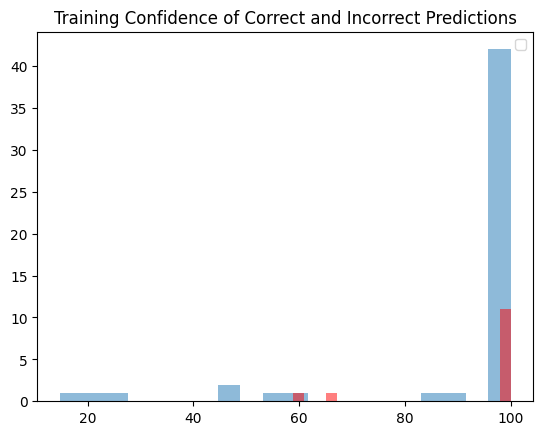

In [135]:

# Because 50% is the baseline confidence, calculate the difference from 50%
confidence = abs(confidence - 50) 

# Then double it so that the difference is between 0 and 100
confidence = confidence * 2

# Make two sets, confidence when we were right, and confidence when we were wrong
correct_confidence = []
incorrect_confidence = []

# Get all the y_test values
actual = y_test.values

for i in range(len(predictions)):
    if predictions[i] == actual[i]:
        correct_confidence.append(confidence[i])
    else:
        incorrect_confidence.append(confidence[i])

# Plot the confidence when we were right and when we were wrong
plt.title('Training Confidence of Correct and Incorrect Predictions')
plt.legend()
plt.hist(correct_confidence, bins=20, alpha=0.5, label='Correct')
plt.hist(incorrect_confidence, bins=20, alpha=0.5, label='Incorrect', color='red')

In [147]:
# Save the weights of the model
import pickle
with open('model.pickle', 'wb') as f:
    pickle.dump(classifier, f)

In [213]:
import csv 

# Load up the data to predict
def predict(games):
    model_inputs = []
    for row in games:
        model_inputs.append(teams_to_stats(stats, 22, fix_names(row[0]), fix_names(row[1])))

    # Convert the data into a dataframe
    model_inputs = pd.DataFrame(model_inputs)

    # Use the transformer to transform the data
    model_inputs = transformer.transform(model_inputs)
 
    # Predict the winner
    predictions = classifier.predict(model_inputs)  
    confidence = classifier.predict_proba(model_inputs)[:, 1] 
    return predictions, confidence

def load_games(path):
    with(open(path, 'r')) as f:
        reader = csv.reader(f)
        games = list(reader)
    return games

games = load_games("input/2022_games.csv")
predictions, confidence = predict(games)

assert len(predictions) == len(confidence)

In [214]:
# Ranking
NumGames = 42

def create_confidence_rankings(games, predictions, confidence):
    rankings = []
    for i in range(len(predictions)):
        abs_conf = abs(confidence[i] - 0.5) 

        rankings.append((games[i], predictions[i], abs_conf))


    rankings.sort(key=lambda x: x[2], reverse=True)
    return rankings


results = (create_confidence_rankings(games, predictions, confidence))

In [217]:
# Convert this into a nice markdown table
output_file = "results.md"
with open(output_file, 'w') as f:
    f.write("# 2022 Bowlmania Predictions\n\n")
    f.write("|Rank|Team 0|Team 1|\n|:---:|:---:|:---:|\n")

    for i in range(len(results)):
        rank = NumGames - i

        team_0 = results[i][0][0]
        team_1 = results[i][0][1]

        # Bold the winner's name
        if results[i][1] == 1:
            team_1 = f"**{team_1}**"
        else:
            team_0 = f"**{team_0}**"

        f.write(f"|{rank}|{team_0}|{team_1}|\n")



In [8]:
def validate(model):
    # Run this model 100 times and average the accuracy
    accuracies = []
    for i in range(100):
        accuracies.append(model())

    print(f'Average accuracy: {np.mean(accuracies)}')

In [53]:
# It is time to learn
def TransformerNB(return_confidence=False):
    from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    from sklearn.model_selection import train_test_split

    # Split the data into training and testing
    X_train, X_test, y_train, y_test = split_data() 

    # Train the transformer
    transformer = StandardScaler()
    transformer.fit(X_train)

    X_train_transformed = transformer.transform(X_train)
    X_test_transformed = transformer.transform(X_test)

    classifier = GaussianNB()
    classifier.fit(X_train_transformed, y_train)
    predictions = classifier.predict(X_test_transformed)
    probs  = classifier.predict_proba(X_test_transformed)
    confidence = probs[:, 1] * 100

    # Calculate the accuracy
    from sklearn.metrics import accuracy_score
    if return_confidence:
        return accuracy_score(y_test, predictions), confidence
    else:
        return accuracy_score(y_test, predictions)

validate(TransformerNB)
# Average accuracy: 0.6628125


Average accuracy: 0.65265625


In [10]:
def ShallowNeuralNetwork():
    from sklearn.neural_network import MLPClassifier
    
    X_train, X_test, y_train, y_test = split_data()
    classifier = MLPClassifier(hidden_layer_sizes=(100, 100), activation='tanh')

    classifier.fit(X_train, y_train)

    predictions = classifier.predict(X_test)
    return (accuracy_score(y_test, predictions))

# validate(ShallowNeuralNetwork) 
# Average accuracy: 0.55515625

In [11]:
def RandomForest():
    from sklearn.ensemble import RandomForestClassifier

    X_train, X_test, y_train, y_test = split_data()
    classifier = RandomForestClassifier(n_estimators=100, max_depth=5)

    classifier.fit(X_train, y_train)

    predictions = classifier.predict(X_test)
    return (accuracy_score(y_test, predictions))

# validate(RandomForest)
# Average accuracy: 0.65109375

In [12]:
def TransformerDNN():
    from sklearn.neural_network import MLPClassifier
    from sklearn.preprocessing import StandardScaler, MinMaxScaler

    # Split the data into training and testing
    X_train, X_test, y_train, y_test = split_data() 

    # Train the transformer
    transformer = StandardScaler()
    transformer.fit(X_train)

    X_train_transformed = transformer.transform(X_train)
    X_test_transformed = transformer.transform(X_test)

    classifier = MLPClassifier(hidden_layer_sizes=(100, 100), activation='relu')

    classifier.fit(X_train_transformed, y_train)

    predictions = classifier.predict(X_test_transformed)
    return (accuracy_score(y_test, predictions))

validate(TransformerDNN)

Average accuracy: 0.614375


In [25]:
# Use Spectral Embedding to reduce the dimensionality of the data
from sklearn.neural_network import MLPClassifier


def SpectralEmbedding():
    from sklearn.manifold import LocallyLinearEmbedding

    X_train, X_test, y_train, y_test = split_data()

    embedding = LocallyLinearEmbedding()
    X_train_transformed = embedding.fit_transform(X_train)
    X_test_transformed = embedding.fit_transform(X_test)

    classifier = MLPClassifier(hidden_layer_sizes=(100, 100), activation='relu')

    classifier.fit(X_train_transformed, y_train)

    predictions = classifier.predict(X_test_transformed)
    return (accuracy_score(y_test, predictions))
print(SpectralEmbedding())

0.46875


In [27]:
# Use GridSearchCV to find the best parameters for the model
from sklearn.model_selection import GridSearchCV

def GridSearch():
    from sklearn.neural_network import MLPClassifier
    from sklearn.preprocessing import StandardScaler, MinMaxScaler

    # Split the data into training and testing
    X_train, X_test, y_train, y_test = split_data() 

    # Train the transformer
    transformer = StandardScaler()
    transformer.fit(X_train)

    X_train_transformed = transformer.transform(X_train)
    X_test_transformed = transformer.transform(X_test)

    classifier = MLPClassifier()

    # Create a dictionary of all the parameters you want to tune
    param_grid = {'hidden_layer_sizes': [(100, 100), (100, 100, 100), (100,)], 'activation': ['relu', 'tanh'], 'solver': ['adam', 'sgd']}

    # Use gridsearch to test all the possible combinations of parameters
    grid = GridSearchCV(classifier, param_grid, refit=True, verbose=3, n_jobs=-1)

    # Fit the model to the data
    grid.fit(X_train_transformed, y_train)

    # Print the best parameters
    print(grid.best_params_)

    # Print the best score
    print(grid.best_score_)

    # Use the best parameters to make predictions
    grid_predictions = grid.predict(X_test_transformed)

    # Print the accuracy
    print(accuracy_score(y_test, grid_predictions))
GridSearch()

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'activation': 'relu', 'hidden_layer_sizes': (100,), 'solver': 'sgd'}
0.675686274509804
0.5


c:\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [40]:
# Use PCA to reduce the dimensionality of the data

def pca():
    from sklearn.decomposition import PCA
    from sklearn.neural_network import MLPClassifier
    from sklearn.preprocessing import StandardScaler, MinMaxScaler

    # Split the data into training and testing
    X_train, X_test, y_train, y_test = split_data() 

    pca = PCA(n_components=2)
    X_train_transformed = pca.fit_transform(X_train)
    X_test_transformed = pca.fit_transform(X_test)

    # Train the transformer
    transformer = StandardScaler()
    transformer.fit(X_train_transformed)

    classifier = MLPClassifier(hidden_layer_sizes=(100, 100), activation='relu')

    classifier.fit(X_train_transformed, y_train)

    predictions = classifier.predict(X_test_transformed)
    return (accuracy_score(y_test, predictions))
print(pca())

0.484375
